In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import random
from math import cos,acos
import shapely
from shapely.geometry import LineString,Point,MultiLineString
import itertools
from numpy.linalg import multi_dot

import matplotlib.pyplot as plt
%matplotlib inline
import statistics
import time

In [2]:
from ipynb.fs.defs.CodeClean_Copy2 import mesh,ActiveNodes,computeDistance,updateLines,TrussVolume
from ipynb.fs.defs.CodeClean_Copy2 import op_D0,op_D,op_T,PlotElem,NodeCheck,IsCrossingD,IsCrossingT,Avail_Nodes
from ipynb.fs.defs.CodeClean_Copy2 import femtruss,Displacement,PossibleActions,sortEle

In [8]:
# funtion to plot the figure
def PlotElem(elemat,grid):
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=0.2, right=2, bottom=0.2, top=0.8)
    ax.set_aspect('equal')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([0,5,10,15,20])
    #ax.set_yticks([])
    x,y = [],[]
    for e in elemat:
        for n in e[1:]:
            x.append(grid[n][0])
            y.append(grid[n][1])
        #print(x,y)
        ax.plot(x, y,color = 'black')
        #plt.text((x[0]+x[1])/2,(y[0]+y[1])/2,e[0])
        x,y = [],[]
    ax.scatter(*zip(*grid),s=10)
    #plt.show()
    #xx,yy = zip(*grid)
    #for i in range(len(grid)):
    #    plt.annotate(str(i), (xx[i] + 0.2, yy[i] + 0.2))

In [4]:
# an action is defined as a = (n,e,Op) where n is the node number, e is the element number and Op is the choice of operator
# 0 = T and 1 = D.

# since not all actions are allowable we randomly pick an action and check if it is allowable and then categorise it by
# storing in either AllowedActions or UnallowedActions


global AllowedActions, UnallowedActions,StateLines
AllowedActions = [[]]
UnallowedActions = [[]]
def randomAction(elemat,grid,state,actions):
    #start = time.process_time()
    found = False
    while not found:
        i = random.randrange(len(actions))
        action = actions[i]
        if i in AllowedActions[state]:
            return i
        elif i in UnallowedActions[state]:
            found = False
        else:
            #print(action)
            n,e,Op = action
            #b = time.process_time()
            if (n,e,Op) == NodeCheck(e,n,Op,elemat,grid):
                AllowedActions[state].append(i)
                #print("nodecheck: ",time.process_time()-b)
                #print("complete: ",time.process_time()-start)
                
                # marking the Q value of unallowed action as -10, to prevent any further selection of the action.
                Q[state, UnallowedActions[state]] = -10 
                
                return i
            else:
                UnallowedActions[state].append(i)
    return None

# funtion to generate a list of all actions
def AllActions(elemat,grid):
    active_nodes,inactive_nodes = ActiveNodes(elemat,len(grid))
    actions = list(itertools.product(inactive_nodes,range(1,np.shape(elemat)[0] + 1),[0,1]))
    return actions

# System 3

In [6]:
#Initializing the grid

#xm = number of rows
#yn = number of columns

xm,yn = 7,5

In [5]:
#y = spacing of rows
#x = spacing of columns

y,x = 5,5 

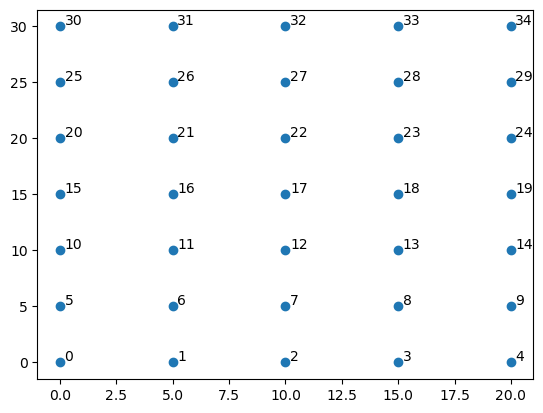

In [9]:
#Generating the mesh for grid
#function "mesh" generates a list of nodes, with each element containing the x and y co-ordinates of the nodes

grid = mesh(xm,yn,y,x)
#print(grid)
plt.scatter(*zip(*grid))
xx,yy = zip(*grid)
for i in range(len(grid)):
    plt.annotate(str(i), (xx[i]+0.2, yy[i] + 0.2))

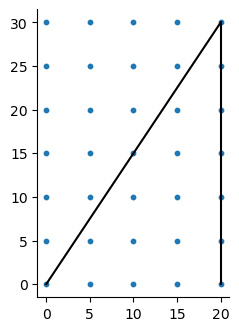

In [13]:
#INPUT DATA to calculate the displacement of the system

#Enter nodal connectivity matrix/ Element matrix
#[element_no, node1, node2]

ele1 = np.array([[1,0,34],
                 [2,4,34]])
'''ele1 = np.array([[1,0,11],
                 [2,2,11]])'''

# Elastic modulus and Area
Emod = 10000
Area = 1

#forces - [force_no, node_no, Direction(0 = X, 1 = Y), Value(N)]

forces = np.array([[1, 34, 0, 10]])

Springs= np.array([])

coeff = 0

#displacements - [S_no, node_no, DoF(0 = X, 1 = Y)]

dispbc = np.array([[1, 0, 0],
                   [2, 0, 1],
                   [3, 4, 0],
                   [4, 4, 1]])

PlotElem(ele1,grid)

[0.1846804164525797]
[array([[ 1,  0, 34],
       [ 2,  4, 34]])]
0.0009804192704222245
0.0015596849870473978


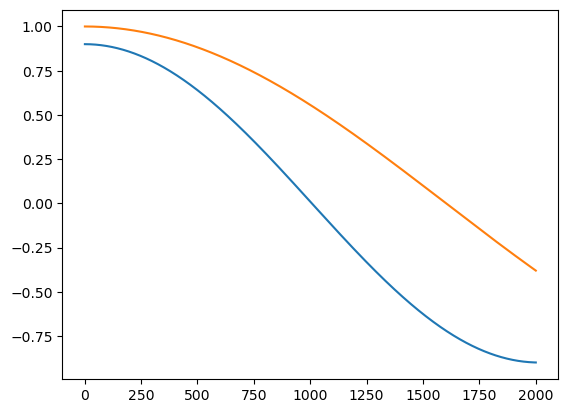

In [20]:
Actions = [AllActions(ele1,grid)] # Stores the list of actions for each state
totalnodes = xm*yn # stores total number of nodes in the grid
active_nodes,inactive_nodes = ActiveNodes(ele1,totalnodes) 
V0 = TrussVolume(ele1,grid)
VolumeMax = 160
Y=[] # Stores displacement values for each state
Qlist = [] 
States = []
Y.append(Displacement(ele1,grid,Area,Emod,forces,dispbc,coeff,Springs))
print(Y)

#hyperparameters
num_episodes = 2000

learning_rate = 0.1
discount_rate = 1

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01

exploration_decay_rate = 0.01 #if we decrease it, will learn slower

#initialise Q table

Stateslist = [list(np.concatenate(ele1).flat)] # stores element matrix as a list
States = [ele1] # stores the element matrices
Qlist = [[States[0],Actions[0]]] # array containing the states and their corresponding actions
print(States)
AllowedActions = [[]]
UnallowedActions = [[]]

maxactions = 500
maxstates = 1000
Q = np.zeros((maxstates,maxactions)) # initializing the Qtable with zeros
Qactions = np.ndarray((maxstates,maxactions),dtype="object") # array storing the element matrices generated by correspoding state action pair

rewards_all_episodes = []

#print(Q)
#print(Qactions)
#B_a = 0.00097
#B_e = 0.0016

# parameters to control the learning rate and exploration rate
from math import *
wavelength1 = ceil(num_episodes*0.5)
wavelength2 = ceil(num_episodes*0.75)
B_a = acos(0.1)/wavelength2
B_e = acos(0.01/0.9)/wavelength1
print(B_a)
print(B_e)
A_e = 0.9
A_a = 1
x = np.arange(1,num_episodes+1)
y = A_e*np.cos(B_e*x) # exploration rate
z = A_a*np.cos(B_a*x) # learning rate
plt.plot(x,y)
plt.plot(x,z)

In [21]:
%%time

avg_rewards = np.zeros((50,num_episodes))
for experiment in range(50):
    rewards_all_episodes = []
    print("Experiment No",experiment)
    for episodes in range(1,num_episodes+1):
        #print("\n","Episode number: ",episodes,"\n")
        state = 0
        done = "False"
        rewards_current_episode = 0
        exploration_rate = A_e*cos(B_e*episodes)
        learning_rate = A_a*cos(B_a*episodes)
        if exploration_rate < 0.01:
            exploration_rate = 0.01
        if learning_rate < 0.1:
            learning_rate = 0.1

        while done == "False":
            #print("state: ",state)
            exploration_rate_threshold = np.random.uniform()
            if exploration_rate_threshold > exploration_rate:
                #print("here")
                actlen = len(Actions[state])
                action = np.argmax(Q[state,0:actlen])
                actions = Actions[state]
                #action = Actions[state][index]
                #print(action)

            else:
                actions = AllActions(States[state],grid)
                action = randomAction(States[state],grid,state,actions)
            #print("action",action)

            n,e,Op = actions[action]
            #print(actions[action])
            #Actions[state][action] #Qlist[state,action]
            start = time.process_time()
            if Op:
                ele2 = op_D(e,n,States[state],grid)
            else:
                ele2 = op_T(e,n,States[state],grid)
            #print(time.process_time()-start)
            Volume = TrussVolume(ele2,grid)
            #print("volume =",Volume)
            active_nodes,inactive_nodes = ActiveNodes(ele2,totalnodes)

            if Volume <= VolumeMax and len(inactive_nodes):
                el_list = list(np.concatenate(ele2).flat)
                r = el_list in Stateslist
                if r:
                    #print("equal to state: ",Stateslist.index(el_list))
                    u = Y[Stateslist.index(el_list)]
                else:
                    #print("about to calculate displacement")
                    #print(ele2,Area,Emod,GetForces(ele1,N,grid),dispbc)
                    u = Displacement(ele2,grid,Area,Emod,forces,dispbc,0,Springs)
                #print("Displacement: ",u)

                if abs(u) <= 2*abs(Y[0]):
                    if not r:
                        States.append(ele2)
                        Stateslist.append(el_list)
                        actions = AllActions(ele2,grid)
                        if len(actions) > maxactions:
                            addlen = len(actions) - maxactions
                            maxactions = len(actions)
                            Q = np.pad(Q, ((0, 0), (0,addlen)), mode='constant',constant_values = -10)
                            Qactions = np.pad(Qactions, ((0, 0), (0,addlen)), mode='constant',constant_values=None)
                        if len(States) > np.shape(Q)[0]:
                            Q = np.concatenate((Q,np.zeros((100,maxactions))))
                            Qactions = np.concatenate((Qactions,np.ndarray((100,maxactions),dtype="object")))
                        Actions.append(actions)
                        UnallowedActions.append([])
                        AllowedActions.append([])
                        Qlist.append([ele2,actions])
                        Y.append(u)
                        #print(ele2)
                    new_state = Stateslist.index(el_list)
                    #print("new state",new_state)

                    #print("Displacement: ",u)
                    Y[new_state] = u
                    reward = min(Y[state] - u,Y[0] - u)
                    rewards_current_episode += reward

                    #print("reward: ",reward)
                    #print("state",state)
                    Q[state,action] = (1 - learning_rate) * Q[state, action] + learning_rate * (reward + discount_rate * np.max(Q[new_state,0:len(Actions[new_state])]))
                    #print("Qvalue: ",Q[state,action])
                    Qactions[state,action] = [ele2]
                    state = new_state
                    #print(state)
                    #PlotElem(ele2,grid)

                else:   
                    Q[state,action] = -10
                    Qactions[state,action] = [ele2]

            else:
                done = "True" 

        rewards_all_episodes.append(rewards_current_episode)
        #print("rewards_current_episode: ",rewards_current_episode)
    avg_rewards[experiment,] = rewards_all_episodes

Experiment No 0
Experiment No 1
Experiment No 2
Experiment No 3
Experiment No 4
Experiment No 5
Experiment No 6
Experiment No 7
Experiment No 8
Experiment No 9
Experiment No 10
Experiment No 11
Experiment No 12
Experiment No 13
Experiment No 14
Experiment No 15
Experiment No 16
Experiment No 17
Experiment No 18
Experiment No 19
Experiment No 20
Experiment No 21
Experiment No 22
Experiment No 23
Experiment No 24
Experiment No 25
Experiment No 26
Experiment No 27
Experiment No 28
Experiment No 29
Experiment No 30
Experiment No 31
Experiment No 32
Experiment No 33
Experiment No 34
Experiment No 35
Experiment No 36
Experiment No 37
Experiment No 38
Experiment No 39
Experiment No 40
Experiment No 41
Experiment No 42
Experiment No 43
Experiment No 44
Experiment No 45
Experiment No 46
Experiment No 47
Experiment No 48
Experiment No 49
Wall time: 8min 58s


In [ ]:
import numpy as np
import time

# Initialize an array to store average rewards for 50 experiments over episodes
avg_rewards = np.zeros((50, num_episodes))

# Loop over 50 experiments
for experiment in range(50):
    rewards_all_episodes = []
    print("Experiment No", experiment)
    
    # Loop over episodes
    for episode in range(1, num_episodes + 1):
        # Initialize episode-specific variables
        state = 0
        done = "False"
        rewards_current_episode = 0
        
        # Calculate exploration and learning rates for this episode
        exploration_rate = A_e * cos(B_e * episode)
        learning_rate = A_a * cos(B_a * episode)
        
        # Ensure that exploration and learning rates don't go below certain thresholds
        if exploration_rate < 0.01:
            exploration_rate = 0.01
        if learning_rate < 0.1:
            learning_rate = 0.1

        # Main episode loop
        while done == "False":
            # Decide whether to explore or exploit based on exploration_rate
            exploration_rate_threshold = np.random.uniform()
            if exploration_rate_threshold > exploration_rate:
                # Exploit: Choose action with highest Q-value
                actlen = len(Actions[state])
                action = np.argmax(Q[state, 0:actlen])
                actions = Actions[state]
            else:
                # Explore: Choose a random action
                actions = AllActions(States[state], grid)
                action = randomAction(States[state], grid, state, actions)
            
            # Extract information about the selected action
            n, e, Op = actions[action]
            
            # Perform an operation (either D or T) based on the action
            if Op:
                ele2 = op_D(e, n, States[state], grid)
            else:
                ele2 = op_T(e, n, States[state], grid)
            
            # Calculate the volume of the truss structure after the operation
            Volume = TrussVolume(ele2, grid)
            
            # Identify active and inactive nodes in the truss structure
            active_nodes, inactive_nodes = ActiveNodes(ele2, totalnodes)
            
            # Check conditions to decide if terminal state or not
            if Volume <= VolumeMax and len(inactive_nodes):
                # Check if the volume of the truss structure is within acceptable limits
                # and if there are inactive nodes in the truss structure

                # Flatten the current truss configuration for comparison
                el_list = list(np.concatenate(ele2).flat)

                # Check if this truss configuration is already known (previously seen)
                r = el_list in Stateslist

                # Calculate displacement for the new truss configuration
                u = Displacement(ele2, grid, Area, Emod, forces, dispbc, 0, Springs)

                # If the configuration is new and displacement meets criteria
                if not r and abs(u) <= 2 * abs(Y[0]):
                    # Add the new truss configuration to the state space and track relevant information

                    # Append the new configuration to the list of known states
                    States.append(ele2)

                    # Append the flattened representation to the list of known state configurations
                    Stateslist.append(el_list)

                    # Generate possible actions for the new state
                    actions = AllActions(ele2, grid)

                    # Ensure the Q-table can accommodate the new actions
                    if len(actions) > maxactions:
                        addlen = len(actions) - maxactions
                        maxactions = len(actions)

                        # Extend the Q-table with new columns for the additional actions
                        Q = np.pad(Q, ((0, 0), (0, addlen)), mode='constant', constant_values=-10)

                        # Extend the Qactions table in a similar manner
                        Qactions = np.pad(Qactions, ((0, 0), (0, addlen)), mode='constant', constant_values=None)

                    # If needed, expand the Q-table to accommodate new states
                    if len(States) > np.shape(Q)[0]:
                        Q = np.concatenate((Q, np.zeros((100, maxactions))))

                        # Extend the Qactions table accordingly
                        Qactions = np.concatenate((Qactions, np.ndarray((100, maxactions), dtype="object")))

                    # Append the possible actions for the new state
                    Actions.append(actions)

                    # Initialize lists to track unallowed and allowed actions (assuming they are defined elsewhere)
                    UnallowedActions.append([])
                    AllowedActions.append([])

                    # Append the new truss configuration and associated actions to the Q-list
                    Qlist.append([ele2, actions])

                    # Append the displacement of the new state to the list of displacements
                    Y.append(u)

                    # Find the index of the new state in the list of known states
                    new_state = Stateslist.index(el_list)

                    # Update the displacement for the new state
                    Y[new_state] = u

                    # Calculate the reward based on the change in displacement
                    reward = min(Y[state] - u, Y[0] - u)

                    # Update the rewards for the current episode
                    rewards_current_episode += reward

                    # Update the Q-value for the current state-action pair using Q-learning
                    Q[state, action] = (1 - learning_rate) * Q[state, action] + learning_rate * (reward + discount_rate * np.max(Q[new_state, 0:len(Actions[new_state])]))

                    # Update the list of actions associated with this state-action pair
                    Qactions[state, action] = [ele2]

                    # Update the current state to the new state for the next step
                    state = new_state

            else:
                # If the conditions are not met, mark the episode as done (terminal state)
                done = "True"


        rewards_all_episodes.append(rewards_current_episode)
    
    # Store the rewards for this experiment
    avg_rewards[experiment,] = rewards_all_episodes


Displacement:  0.1846804164525797
Volume:  66.05551275463989
state: 0
action:  76
Q:  0.1125798569012001
Displacement:  0.1157841589206733
Volume:  93.64328450540825
state:  68
action:  114
Q:  0.04368359936929369
Displacement:  0.09279559937398751
Volume:  131.88107967744298
i: 1037
262
Q:  0.020695039822607897
Displacement:  0.07210055955137962
Volume:  159.2417594524409
i: 2751
0
Q:  0.0


TypeError: 'NoneType' object is not subscriptable

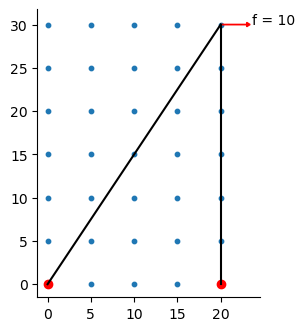

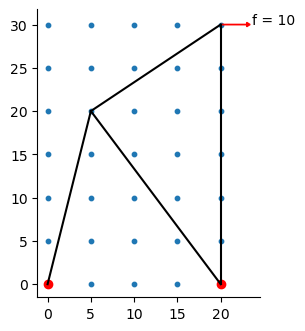

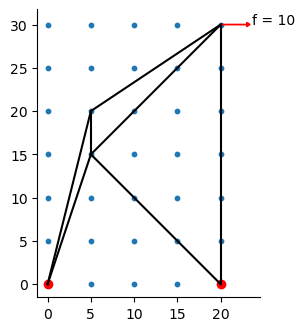

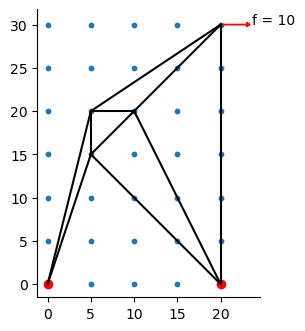

In [24]:
# a trivial approach to find the optimised sequence of actions.
# starting with the state 0, we select the action with the highest Q value
# we then find the index of the new state obtained after performing the action
# now we apply a recursive approach by finding the action with the highest Q value 
# and repeating the whole process. Until we reach the terminal state

PlotElem(ele1,grid)
a = np.unique(dispbc[:,1])
grid_mat = np.array(grid)
plt.scatter(grid_mat[a,0],grid_mat[a,1],color='red')
plt.arrow(grid[34][0],grid[34][1], 3, 0, head_width=0.5, head_length=0.4, fc='r', ec='r')
plt.annotate('f = 10', xy=(23.6, 30))

print("Displacement: ",Y[0])
print("Volume: ",TrussVolume(ele1,grid) )
max = np.argmax(Q[0,:]) # starting with the state 0, we select the action with the highest Q value
print("state: 0")
print("action: ",max)
print("Q: ",Q[0,max])
#max = 7
PlotElem(Qactions[0,max][0],grid)
a = np.unique(dispbc[:,1])
grid_mat = np.array(grid)
plt.scatter(grid_mat[a,0],grid_mat[a,1],color='red')
plt.arrow(grid[34][0],grid[34][1], 3, 0, head_width=0.5, head_length=0.4, fc='r', ec='r')
plt.annotate('f = 10', xy=(23.6, 30))

print("Displacement: ",Displacement(Qactions[0,max][0],grid,Area,Emod,forces,dispbc,coeff,Springs))
print("Volume: ",TrussVolume(Qactions[0,max][0],grid))
s = list(np.concatenate(Qactions[0,max][0]).flat) # converting the element matrix to a list 
i = Stateslist.index(s) # we then find the index of the new state obtained after performing the action
print("state: ",i)
max = np.argmax(Q[i,:]) # now we apply a recursive approach by finding the action with the highest Q value 
print("action: ",max)
print("Q: ",Q[i,max])
PlotElem(Qactions[i,max][0],grid)
a = np.unique(dispbc[:,1])
grid_mat = np.array(grid)
plt.scatter(grid_mat[a,0],grid_mat[a,1],color='red')
plt.arrow(grid[34][0],grid[34][1], 3, 0, head_width=0.5, head_length=0.4, fc='r', ec='r')
plt.annotate('f = 10', xy=(23.6, 30))

print("Displacement: ",Displacement(Qactions[i,max][0],grid,Area,Emod,forces,dispbc,coeff,Springs))
print("Volume: ",TrussVolume(Qactions[i,max][0],grid) )
s = list(np.concatenate(Qactions[i,max][0]).flat)
i = Stateslist.index(s)
print("i:",i)
max = np.argmax(Q[i,:])
print(max)
print("Q: ",Q[i,max])
PlotElem(Qactions[i,max][0],grid)
a = np.unique(dispbc[:,1])
grid_mat = np.array(grid)
plt.scatter(grid_mat[a,0],grid_mat[a,1],color='red')
plt.arrow(grid[34][0],grid[34][1], 3, 0, head_width=0.5, head_length=0.4, fc='r', ec='r')
plt.annotate('f = 10', xy=(23.6, 30))
print("Displacement: ",Displacement(Qactions[i,max][0],grid,Area,Emod,forces,dispbc,coeff,Springs))
print("Volume: ",TrussVolume(Qactions[i,max][0],grid))
s = list(np.concatenate(Qactions[i,max][0]).flat)
i = Stateslist.index(s)
print("i:",i)
max = np.argmax(Q[i,:])
print(max)
print("Q: ",Q[i,max])
PlotElem(Qactions[i,max][0],grid)
a = np.unique(dispbc[:,1])
grid_mat = np.array(grid)
plt.scatter(grid_mat[a,0],grid_mat[a,1],color='red')
plt.arrow(grid[34][0],grid[34][1], 3, 0, head_width=0.5, head_length=0.4, fc='r', ec='r')
plt.annotate('f = 10', xy=(23.6, 30))
print("Displacement: ",Displacement(Qactions[i,max][0],grid,Area,Emod,forces,dispbc,coeff,Springs))
print("Volume: ",TrussVolume(Qactions[i,max][0],grid))

In [81]:
len(States)

166

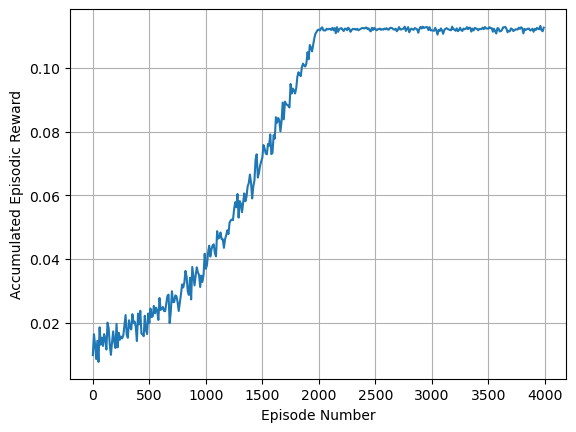

In [46]:
avgResult = np.average(np.mean(avg_rewards,axis=0).reshape(-1, 10), axis=1)
plt.plot(range(0,num_episodes,10),avgResult)
#plt.scatter(range(0,num_episodes,10),avgResult,s = 4,color = 'black')
plt.xlabel("Episode Number")
plt.ylabel("Accumulated Episodic Reward")
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([0.015, 0.1])
ax.grid(True)

# END

********** Average  reward per thousand episodes **********

10 :  0.015240839201150658
20 :  -0.00016555730096600024
30 :  -0.007566035041162521
40 :  0.011912903012851462
50 :  0.03923835023263824
60 :  0.020589427542089263
70 :  0.008983357965795618
80 :  0.043554347726095274
90 :  0.04692281910134942
100 :  0.01788541238251764
110 :  0.03376551221444663
120 :  0.012709063492544834
130 :  0.02568790760796828
140 :  0.04265286346328469
150 :  0.035730696119216004
160 :  0.03714879267990705
170 :  0.007554341684332807
180 :  -0.020716567546246643
190 :  0.002546021535054109
200 :  0.025095237853160528
210 :  0.02774667121695964
220 :  -0.006074788018203432
230 :  0.015260565918983431
240 :  0.029895622397537208
250 :  0.02596210871902403
260 :  -0.011035187644847396
270 :  -0.019279723145952558
280 :  0.026066189779587134
290 :  0.010163996016360281
300 :  -0.0032701000444692874
310 :  0.006507572395929653
320 :  0.04832245166457439
330 :  -0.013944964638771897
340 :  0.03724196528849

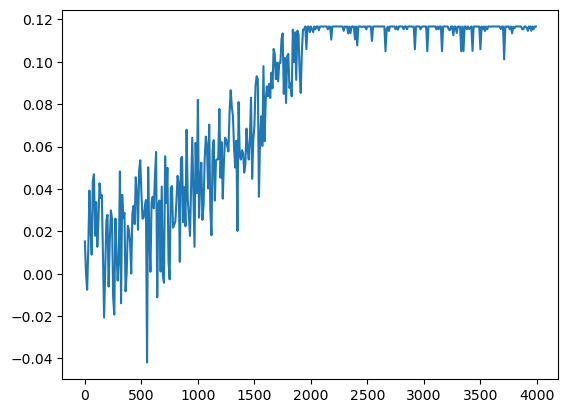

In [47]:
# Calculate and print the average reward per 10 episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes / 10)
count = 10
print("********** Average  reward per thousand episodes **********\n")


mean = []
for r in rewards_per_thousand_episodes:
    #print(count, ": ", str(sum(r/10)))
    cum_sum = statistics.fmean(r)
    mean.append(cum_sum)
    print(count,": ", cum_sum)
    count += 10
    
plt.plot([i for i in range(0,num_episodes,10)],mean)

In [48]:
sorted(Y)[0]

0.06780942667061186